# Extracting Lagrangian-averaged vorticity deviation (LAVD) from an example velocity field

In [1]:
from parcels import FieldSet, Field
from glob import glob
import os
from os.path import join
import numpy as np
import xarray as xr
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import cmocean
import gsw
from xgcm.grid import Grid


seconds_per_day = 24 * 60 * 60
deg_to_m = 1852 * 60  # m per degree

In [2]:
%load_ext autoreload
%autoreload 2
# %reload_ext autoreload #if you are doing it again
import sys

sys.path.append("../xlcs/")

import lagrangian_tools as lt
import grid_calc
from custommap import *
from contours import extract_contours

/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


# Load 15 day-long velocity fields over the Gulf of Mexico

The velocity field, from sea surface height measured by altimetry, was obtained from http://marine.copernicus.eu.

In [3]:


# from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
from numpy import arange, ones
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.cm import get_cmap
from matplotlib import colors 
from matplotlib.colors import ListedColormap
from matplotlib.figure import Figure


# # this chunk is for eddy observation figures
# from py_eddy_tracker.observations.observation import EddiesObservations, Table
# from py_eddy_tracker.observations.tracking import TrackEddiesObservations
# from py_eddy_tracker.dataset.grid import RegularGridDataset
# from py_eddy_tracker.featured_tracking.area_tracker import AreaTracker
# from py_eddy_tracker.gui import GUI
# from py_eddy_tracker.tracking import Correspondances
from datetime import datetime, timedelta
from netCDF4 import Dataset

import io
import os
import warnings
warnings.filterwarnings("ignore")

# from concurrent.futures import ProcessPoolExecutor
# from concurrent.futures import ThreadPoolExecutor

import dask
from dask_jobqueue import SLURMCluster
from dask.distributed import Client

import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,LatitudeLocator)
import cartopy.feature as cfeature

import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import glob
import intake
from pathlib import Path
import dask
import cmocean.cm as cmo #also for pretty color palettes
import pandas as pd
dask.config.set({"array.slicing.split_large_chunks": True}) 
import sys

# to access intake catalog of eerie
eerie_cat=intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")

# for pretty color palettes
# import colorcet as cc

# this is the fake package from the kackathon folder

# import tol_colors as tc

In [8]:
#### this is for native grid

# eerie_cat=intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")

# data_oce = eerie_cat["dkrz"]["disk"]["model-output"]["icon-esm-er"]["eerie-control-1950"]["v20231106"]["ocean"]["native"]["2d_daily_mean"].to_dask()

# def prep_data(ds):
#     ds = ds.rename({"ncells": "cell"})
#     return ds

# data_oce = prep_data(data_oce)
# data_oce

<xarray.Dataset> Size: 26TB
Dimensions:                              (time: 13879, cell: 14886338, lev: 1,
                                          depth: 1, ncells_2: 22375924)
Coordinates:
  * depth                                (depth) float64 8B 1.0
    lat                                  (cell) float64 119MB dask.array<chunksize=(14886338,), meta=np.ndarray>
  * lev                                  (lev) float64 8B 0.0
    lon                                  (cell) float64 119MB dask.array<chunksize=(14886338,), meta=np.ndarray>
  * time                                 (time) datetime64[ns] 111kB 2002-01-...
Dimensions without coordinates: cell, ncells_2
Data variables: (12/32)
    Wind_Speed_10m                       (time, cell) float32 826GB dask.array<chunksize=(5, 4976640), meta=np.ndarray>
    atmos_fluxes_FrshFlux_Evaporation    (time, cell) float32 826GB dask.array<chunksize=(5, 4976640), meta=np.ndarray>
    atmos_fluxes_FrshFlux_Precipitation  (time, cell) float32 826GB dask.array<chunksize=(5, 4976640), meta=np.ndarray>
    atmos_fluxes_FrshFlux_Runoff         (time, cell) float32 826GB dask.array<chunksize=(5, 4976640), meta=np.ndarray>
    atmos_fluxes_FrshFlux_SnowFall       (time, cell) float32 826GB dask.array<chunksize=(5, 4976640), meta=np.ndarray>
    atmos_fluxes_HeatFlux_Latent         (time, cell) float32 826GB dask.array<chunksize=(5, 4976640), meta=np.ndarray>
    ...                                   ...
    ssh                                  (time, cell) float32 826GB dask.array<chunksize=(5, 4976640), meta=np.ndarray>
    stretch_c                            (time, cell) float32 826GB dask.array<chunksize=(5, 4976640), meta=np.ndarray>
    to                                   (time, depth, cell) float32 826GB dask.array<chunksize=(4, 1, 6967296), meta=np.ndarray>
    u                                    (time, depth, cell) float32 826GB dask.array<chunksize=(4, 1, 6967296), meta=np.ndarray>
    v                                    (time, depth, cell) float32 826GB dask.array<chunksize=(4, 1, 6967296), meta=np.ndarray>
    verticallyTotal_mass_flux_e          (time, ncells_2) float32 1TB dask.array<chunksize=(5, 5099520), meta=np.ndarray>
Attributes: (12/34)
    CDI:                      Climate Data Interface version 2.2.0 (https://m...
    Conventions:              CF-1.6
    DOKU_License:             CC BY 4.0
    DOKU_Name:                EERIE ICON-ESM-ER eerie-control-1950 run
    DOKU_authors:             Putrasahan, D.; Kröger, J.; Wachsmann, F.
    DOKU_responsible_person:  Fabian Wachsmann
    ...                       ...
    source_type:              AOGCM
    time_max:                 28401119
    time_min:                 27351359
    time_reduction:           mean
    title:                    ICON simulation
    uuidOfHGrid:              375cb0cc-637e-11e8-9d6f-8f41a9b9ff4b

In [4]:
#### this is for regridded

eerie_cat=intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")

data_oce = eerie_cat["dkrz"]["disk"]["model-output"]["icon-esm-er"]["eerie-control-1950"]["v20231106"]["ocean"]["gr025"]["2d_daily_mean"].to_dask()

data_oce

<xarray.Dataset> Size: 2TB
Dimensions:                              (time: 13879, lat: 721, lon: 1440,
                                          lev: 1, depth: 1)
Coordinates:
  * depth                                (depth) float64 8B 1.0
  * lat                                  (lat) float64 6kB -90.0 -89.75 ... 90.0
  * lev                                  (lev) float64 8B 0.0
  * lon                                  (lon) float64 12kB 0.0 0.25 ... 359.8
  * time                                 (time) datetime64[ns] 111kB 2002-01-...
Data variables: (12/30)
    Wind_Speed_10m                       (time, lat, lon) float32 58GB dask.array<chunksize=(32, 721, 1440), meta=np.ndarray>
    atmos_fluxes_FrshFlux_Evaporation    (time, lat, lon) float32 58GB dask.array<chunksize=(32, 721, 1440), meta=np.ndarray>
    atmos_fluxes_FrshFlux_Precipitation  (time, lat, lon) float32 58GB dask.array<chunksize=(32, 721, 1440), meta=np.ndarray>
    atmos_fluxes_FrshFlux_Runoff         (time, lat, lon) float32 58GB dask.array<chunksize=(32, 721, 1440), meta=np.ndarray>
    atmos_fluxes_FrshFlux_SnowFall       (time, lat, lon) float32 58GB dask.array<chunksize=(32, 721, 1440), meta=np.ndarray>
    atmos_fluxes_HeatFlux_Latent         (time, lat, lon) float32 58GB dask.array<chunksize=(32, 721, 1440), meta=np.ndarray>
    ...                                   ...
    so                                   (time, depth, lat, lon) float32 58GB dask.array<chunksize=(32, 1, 721, 1440), meta=np.ndarray>
    ssh                                  (time, lat, lon) float32 58GB dask.array<chunksize=(32, 721, 1440), meta=np.ndarray>
    stretch_c                            (time, lat, lon) float32 58GB dask.array<chunksize=(32, 721, 1440), meta=np.ndarray>
    to                                   (time, depth, lat, lon) float32 58GB dask.array<chunksize=(32, 1, 721, 1440), meta=np.ndarray>
    u                                    (time, depth, lat, lon) float32 58GB dask.array<chunksize=(32, 1, 721, 1440), meta=np.ndarray>
    v                                    (time, depth, lat, lon) float32 58GB dask.array<chunksize=(32, 1, 721, 1440), meta=np.ndarray>
Attributes: (12/33)
    CDI:                       Climate Data Interface version 2.2.4 (https://...
    CDO:                       Climate Data Operators version 2.2.2 (https://...
    Conventions:               CF-1.6
    DOKU_License:              CC BY 4.0
    DOKU_Name:                 EERIE ICON-ESM-ER eerie-control-1950 run
    DOKU_authors:              Putrasahan, D.; Kröger, J.; Wachsmann, F.
    ...                        ...
    source_id:                 ICON-ESM
    source_type:               AOGCM
    time_max:                  1095839
    time_min:                  1439
    time_reduction:            mean
    title:                     ICON simulation

In [5]:
### subset data to have like 100 days and only u and v velocity components
# data_sample = data_oce["ssh"].isel(time=70)
data_sub=data_oce.sel(time="2002-03")
data_sub=data_sub[["u", "v"]]
data_sub

<xarray.Dataset> Size: 258MB
Dimensions:  (time: 31, depth: 1, lat: 721, lon: 1440)
Coordinates:
  * depth    (depth) float64 8B 1.0
  * lat      (lat) float64 6kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time     (time) datetime64[ns] 248B 2002-03-01T23:59:00 ... 2002-03-31T23...
Data variables:
    u        (time, depth, lat, lon) float32 129MB dask.array<chunksize=(5, 1, 721, 1440), meta=np.ndarray>
    v        (time, depth, lat, lon) float32 129MB dask.array<chunksize=(5, 1, 721, 1440), meta=np.ndarray>
Attributes: (12/33)
    CDI:                       Climate Data Interface version 2.2.4 (https://...
    CDO:                       Climate Data Operators version 2.2.2 (https://...
    Conventions:               CF-1.6
    DOKU_License:              CC BY 4.0
    DOKU_Name:                 EERIE ICON-ESM-ER eerie-control-1950 run
    DOKU_authors:              Putrasahan, D.; Kröger, J.; Wachsmann, F.
    ...                        ...
    source_id:                 ICON-ESM
    source_type:               AOGCM
    time_max:                  1095839
    time_min:                  1439
    time_reduction:            mean
    title:                     ICON simulation

In [6]:
data_sub['v']=data_sub['v'][:,0,:,:]
data_sub['u']=data_sub['u'][:,0,:,:]

In [8]:
data_sub

<xarray.Dataset> Size: 258MB
Dimensions:  (time: 31, lat: 721, lon: 1440, depth: 1)
Coordinates:
  * depth    (depth) float64 8B 1.0
  * lat      (lat) float64 6kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time     (time) datetime64[ns] 248B 2002-03-01T23:59:00 ... 2002-03-31T23...
Data variables:
    u        (time, lat, lon) float32 129MB dask.array<chunksize=(5, 721, 1440), meta=np.ndarray>
    v        (time, lat, lon) float32 129MB dask.array<chunksize=(5, 721, 1440), meta=np.ndarray>
Attributes: (12/33)
    CDI:                       Climate Data Interface version 2.2.4 (https://...
    CDO:                       Climate Data Operators version 2.2.2 (https://...
    Conventions:               CF-1.6
    DOKU_License:              CC BY 4.0
    DOKU_Name:                 EERIE ICON-ESM-ER eerie-control-1950 run
    DOKU_authors:              Putrasahan, D.; Kröger, J.; Wachsmann, F.
    ...                        ...
    source_id:                 ICON-ESM
    source_type:               AOGCM
    time_max:                  1095839
    time_min:                  1439
    time_reduction:            mean
    title:                     ICON simulation

In [11]:
# ds0=data_sub.drop_dims("depth")
# ds0

## Create grid to easily perform derivative with XGCM
- create grid spacing variable (`dx`, `dy`) with values in meters
- because new values are not stored at the same location as the velocity we create two new dimensions
    - `longitude`, `latitude`: The variable values are located at the cell center.
    - `longitude_g`, `latitude_g`: The variable values are located on the cell faces, excluding both outer boundaries.
    - See [Simple Grids](https://xgcm.readthedocs.io/en/latest/grids.html) for more details.
- create the Grid object

In [7]:
ds0=data_sub

In [8]:
ds = ds0.copy(deep=True)


lon, lat = np.meshgrid(ds.lon, ds.lat)
ds = ds.assign_coords(
    {
        "dx": xr.DataArray(
            gsw.distance(lon, lat, axis=1),
            dims=["lat", "longitude_g"],
            coords={
                "lat": ds.lat.data,
                "longitude_g": 0.5 * (ds.lon.data[1:] + ds.lon.data[:-1]),
            },
        ),
        "dy": xr.DataArray(
            gsw.distance(lon, lat, axis=0),
            dims=["latitude_g", "lon"],
            coords={
                "latitude_g": 0.5 * (ds.lat.data[1:] + ds.lat.data[:-1]),
                "lon": ds.lon.data,
            },
        ),
    }
)

## XGCM velocity grid object

In [9]:
coords = {
    "X": {"center": "lon", "inner": "longitude_g"},
    "Y": {"center": "lat", "inner": "latitude_g"},
}
grid = Grid(ds, periodic=[], coords=coords)
grid

<xgcm.Grid>
X Axis (not periodic, boundary=None):
  * center   lon --> inner
  * inner    longitude_g --> center
Y Axis (not periodic, boundary=None):
  * center   lat --> inner
  * inner    latitude_g --> center

# Trajectories (using OceanParcels)

## Velocity fields
- create the FieldSet for Parcels integration

In [10]:
variables = {"U": "u", "V": "v"}

dimensions = {
    "time": "time",
    "lon": "lon",
    "lat": "lat",
}

fs = FieldSet.from_xarray_dataset(ds, variables, dimensions, mesh="spherical")

In [13]:
fs.time_origin  # validate

2002-03-01T23:59:00.000000000

## Vorticity

LAVD requires interpolating the vorticity along the trajectories, so we include it as an extra field to the Parcel's fieldset object `fs`. 

Note: the derivatives are interpolated back to the center of the cells.

In [19]:
# ds=ds.drop_dims("depth")

In [11]:
vg_x = grid.diff(ds.v, "X", boundary="extend") / ds.dx
ug_y = grid.diff(ds.u, "Y", boundary="extend") / ds.dy
ds["vorticity"] = grid.interp(vg_x, "X", to="center", boundary="extend") - grid.interp(
    ug_y, "Y", to="center", boundary="extend"
)

In [12]:
# add the field to the FS object
field1 = Field.from_xarray(ds["vorticity"], "vorticity", dimensions)
fs.add_field(field1)

### Validate the vorticity

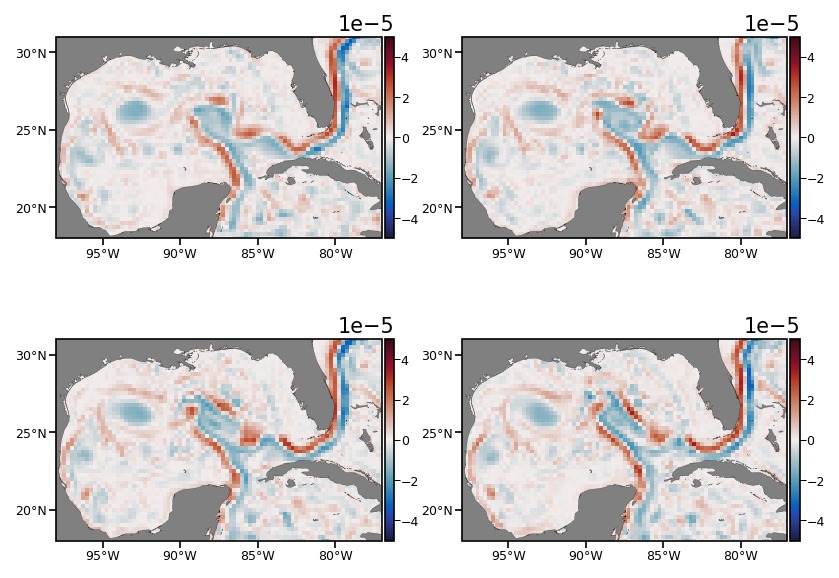

In [13]:
fig = plt.figure(dpi=150)
ax1 = fig.add_subplot(2, 2, 1, aspect="equal", projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(2, 2, 2, aspect="equal", projection=ccrs.PlateCarree())
ax3 = fig.add_subplot(2, 2, 3, aspect="equal", projection=ccrs.PlateCarree())
ax4 = fig.add_subplot(2, 2, 4, aspect="equal", projection=ccrs.PlateCarree())
axes = [ax1, ax2, ax3, ax4]

for i in range(0, 4):
    pcm = axes[i].pcolormesh(
        ds.lon,
        ds.lat,
        ds.vorticity.isel(time=4 * i),
        cmap=cmocean.cm.balance,
        vmin=-5e-5,
        vmax=5e-5,
    )
    gom_map(axes[i])
    add_colorbar(fig, axes[i], pcm)

## Trajectories
- we create a second grid where trajectories will be launched since it does not have to be equal to the velocity grid.

2002-03-01T23:59:00.000000000


In [42]:
# parameters
t0 = datetime(2002, 3, 6)
# t0 = datetime(1995, 1, 15)
adv_time = timedelta(days=8)
adv_dt = timedelta(hours=0.6)
pdist = 0.025  # distance in degrees between particles
lon = [262, 272]
lat = [17, 27]
output_folder = "./"


# # original parameters
# t0 = datetime(1995, 1, 15)
# adv_time = timedelta(days=10)
# adv_dt = -timedelta(hours=6)
# pdist = 0.025  # distance in degrees between particles
# lon = [-98, -75]
# lat = [17, 31]
# output_folder = "./"

In [43]:
px = np.arange(lon[0], lon[1] - pdist, pdist)
py = np.arange(lat[0], lat[1] + pdist, pdist)
px_grid, py_grid = np.meshgrid(px, py)

ds_traj = xr.Dataset().assign_coords(
    {
        "dx": xr.DataArray(
            gsw.distance(px_grid, py_grid, axis=1),
            dims=["yc", "xg"],
            coords={"yc": py, "xg": 0.5 * (px[1:] + px[:-1])},
        ),
        "dy": xr.DataArray(
            gsw.distance(px_grid, py_grid, axis=0),
            dims=["yg", "xc"],
            coords={"yg": 0.5 * (py[1:] + py[:-1]), "xc": px},
        ),
    }
)


coords = {
    "X": {"center": "xc", "inner": "xg"},
    "Y": {"center": "yc", "inner": "yg"},
}
grid_traj = Grid(ds_traj, periodic=[], coords=coords)
grid_traj

<xgcm.Grid>
X Axis (not periodic, boundary=None):
  * center   xc --> inner
  * inner    xg --> center
Y Axis (not periodic, boundary=None):
  * center   yc --> inner
  * inner    yg --> center

In [44]:
pset, id0 = lt.flowmap(
    ds_traj,
    join(output_folder, f"lavd_{t0.strftime('%Y%m%d')}.zarr"),
    fs,
    t0,
    adv_time,
    adv_dt,
    lavd=True,
)

INFO: Output files are stored in ./lavd_20020306.zarr.
100%|██████████| 691200.0/691200.0 [02:01<00:00, 5678.47it/s]


## Integrate the vorticity sampled along the trajectory

In [45]:
# calculate LAVD from the Parcel's outputs
with xr.open_dataset(
    join(output_folder, f"lavd_{t0.strftime('%Y%m%d')}.zarr")
) as ds_out:
    ds_traj["lavd"] = (
        ("yc", "xc"),
        lt.lavd(
            ds_out,
            np.nanmean(ds["vorticity"]),
            # int(abs(adv_dt.total_seconds())),
            adv_dt,
            adv_time,
            id0,
            ds_traj["phi_x"].shape,
        ),
    )

In [20]:
adv_time

datetime.timedelta(days=10)

In [24]:
int(abs(adv_time.total_seconds()))

691200

## Plot results

### Lagrangian Averaged Vorticity Deviation (LAVD)

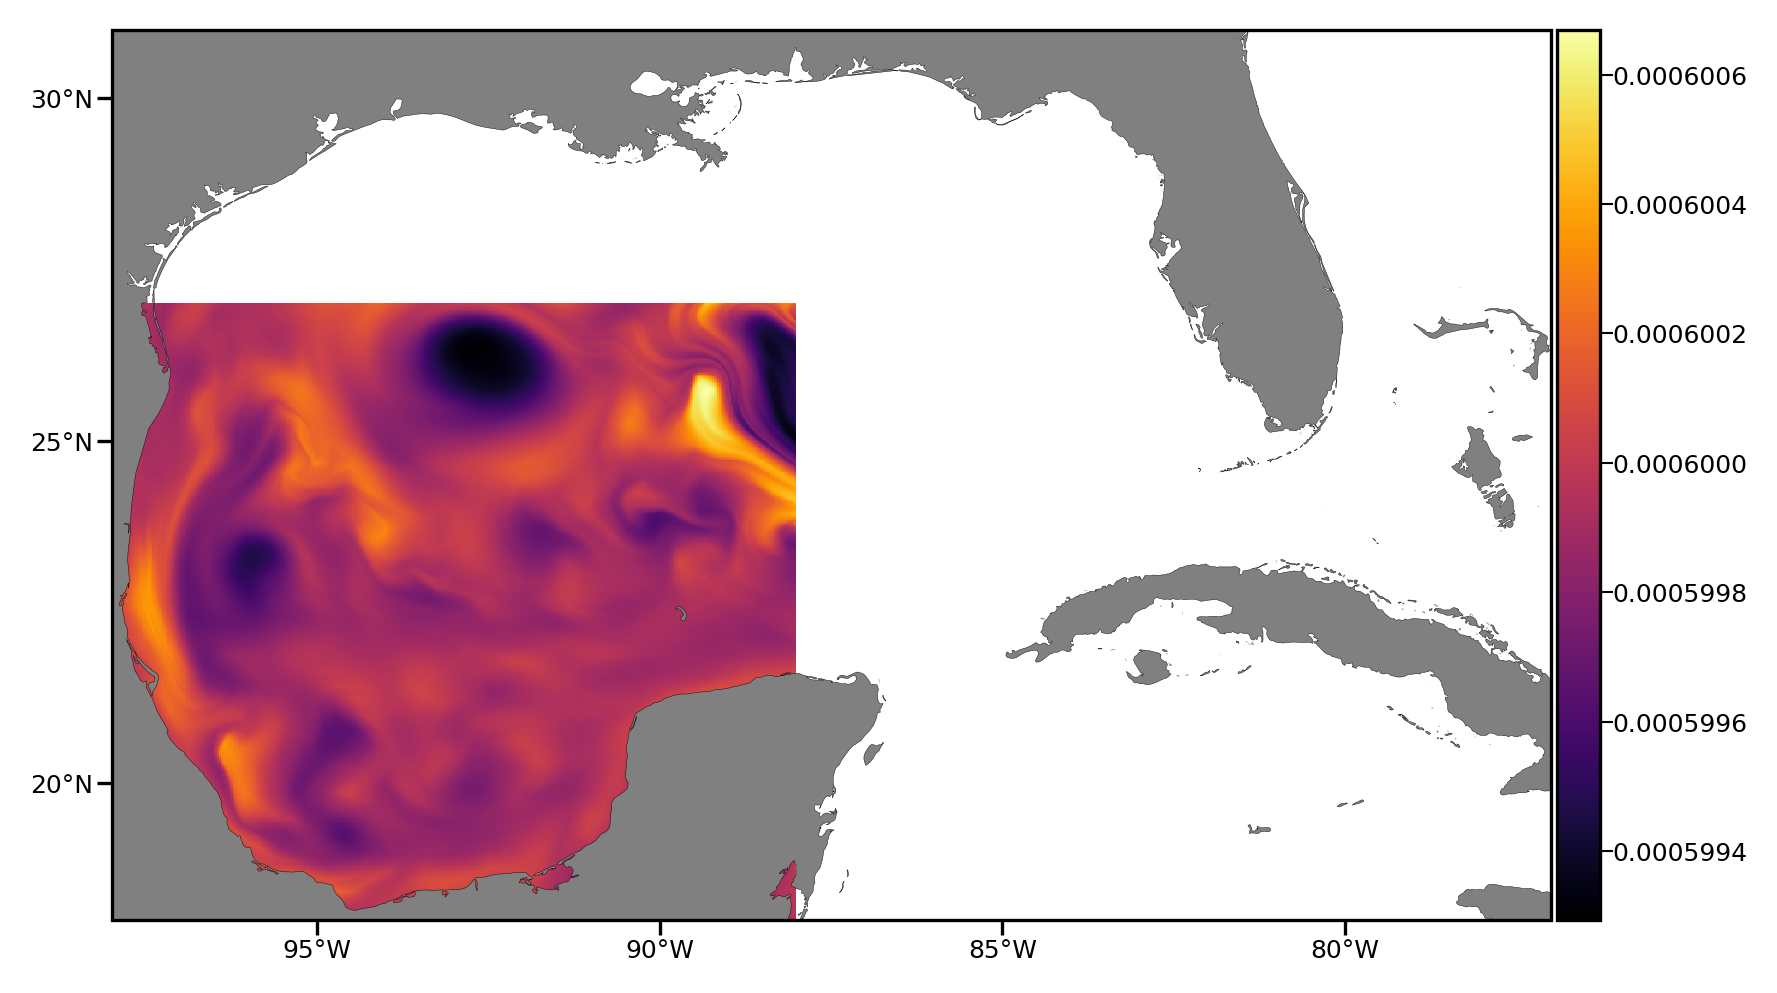

In [46]:
fig = plt.figure(dpi=300)
ax1 = fig.add_subplot(1, 1, 1, aspect="equal", projection=ccrs.PlateCarree())

pcm = ax1.pcolormesh(ds_traj.xc, ds_traj.yc, ds_traj.lavd, cmap="inferno")
gom_map(ax1)
add_colorbar(fig, ax1, pcm)

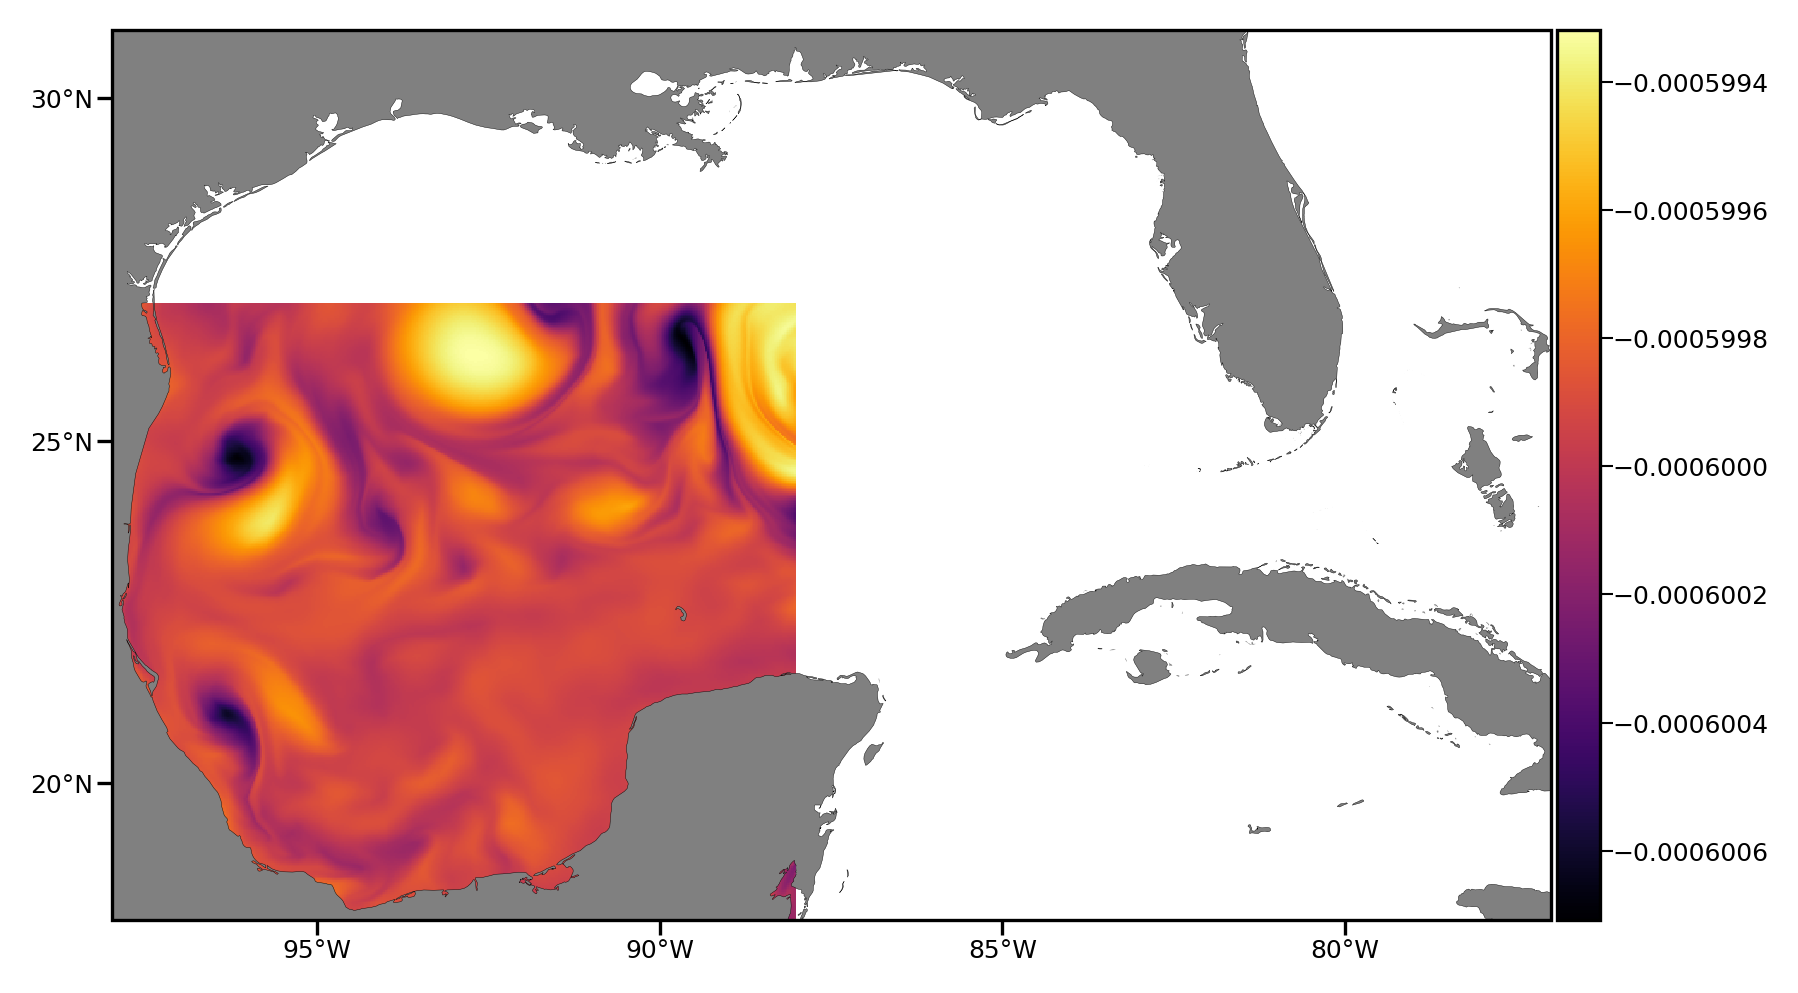

In [41]:
fig = plt.figure(dpi=300)
ax1 = fig.add_subplot(1, 1, 1, aspect="equal", projection=ccrs.PlateCarree())

pcm = ax1.pcolormesh(ds_traj.xc, ds_traj.yc, ds_traj.lavd, cmap="inferno")
gom_map(ax1)
add_colorbar(fig, ax1, pcm)

# Extract LAVD contours

In [47]:
# parameters
defTol = 0.075  # [%] control the deficiency of the loop closer to 0 means perfectly convex (no filamentation)
max_radius = 3  # degree (so ~300 km)

# try extracting contours around each identified peaks
# number_levels represents the number of "test" contour between [0, peak_lavd_value]
number_levels = 50
peaks_xy, peaks_contour = extract_contours(ds_traj, defTol, max_radius, number_levels)

QH6214 qhull input error: not enough points(2) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2058429163  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

QH6214 qhull input error: not enough points(2) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2058429163  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

QH6214 qhull input error: not enough points(2) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2058445970  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

QH6214 qhull input error: not enough points(2) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2058462777  incidence  Qtriangulate  _pre-merge  _zero-centru

## Plot identified contours

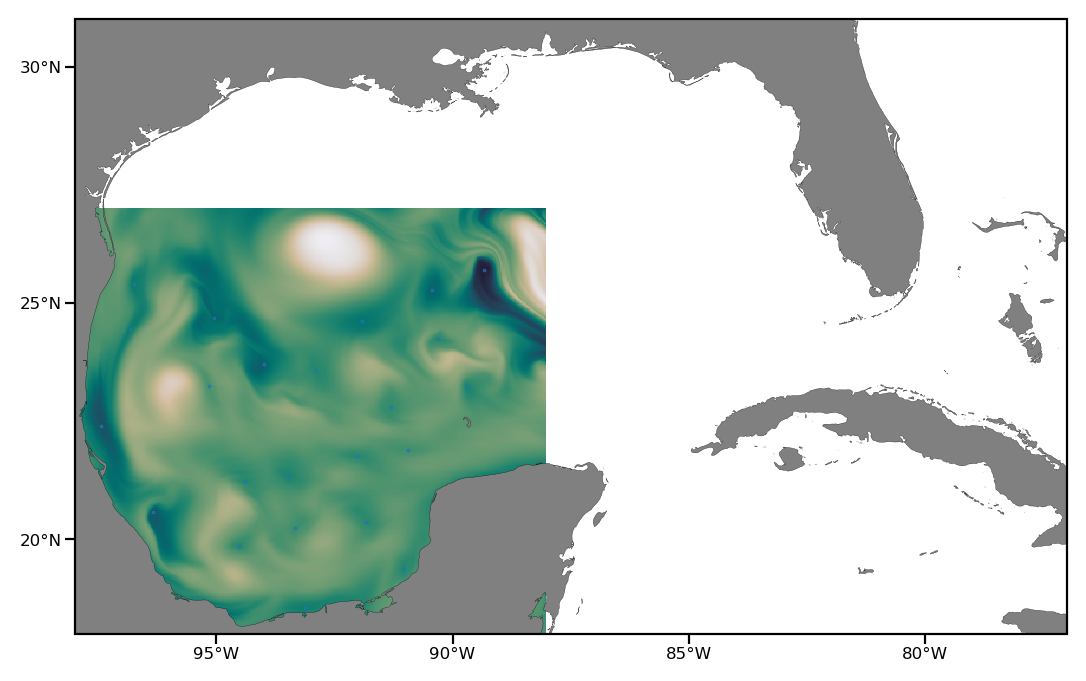

In [48]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(1, 1, 1, aspect="equal", projection=ccrs.PlateCarree())
pcm = ax.pcolormesh(ds_traj["xc"], ds_traj["yc"], ds_traj["lavd"], cmap=cmocean.cm.rain)

cc = 0
for c in peaks_contour:
    if c is not None:
        ax.plot(c[:, 1], c[:, 0], linewidth=0.5)

ax.scatter(
    ds_traj["xc"].values[peaks_xy[:, 1]], ds_traj["yc"].values[peaks_xy[:, 0]], s=0.1
)
gom_map(ax)

## now I run the same thing only for a very small area so i can use it as an example for exploring trajectories